In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
V0 = 3.0  # Delta potential strength
mass = 1.0
hbar = (1/5)**0.5
E = 2.0
k = np.sqrt(2 * mass * E) / hbar  # Wave number

# Single channel (no j indices)
n_ch = 1

# Spatial grids
x = np.linspace(-40, 40, 5000)
x_prime = np.linspace(-40, 40, 5000)
dx = x[1] - x[0]

print(f"Wave number k: {k:.6f}")
print(f"Energy E: {E}")
print(f"Delta potential strength V0: {V0}")


Wave number k: 4.472136
Energy E: 2.0
Delta potential strength V0: 3.0


In [ ]:
import numpy as np

# Parameters
V0 = 3.0      # Delta function strength
mass = 1.0    # Particle mass
hbar = (1/5)**0.5  # Reduced Planck's
E = 2.0        # Energy

# Spatial grid parameters
N = 5000
L = 40.0
xi = 10.0
x = np.linspace(-L, L, N)
dx = x[1] - x[0]
k = np.sqrt(2 * mass * E)/(hbar)
delta_x = 0.01

# Compute Gaussian potential
def compute_delta_potential(x_p):
    sigma = delta_x  # Your specified width
    return (V0 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-x_p**2 / (2 * sigma**2))
    # m_vals = np.array([-1, 0, 1])
    # xi = 10.0
    # return np.sum([V0 * np.exp(-(x_p - m*xi)**2) for m in m_vals])

potential = np.array([compute_delta_potential(x_j) for x_j in x])

# Build full K matrix using meshgrid-like approach
K = np.zeros((N, N), dtype=np.complex128)
gamma = -1j * mass * dx / (hbar**2 * k)  # Prefactor

# Populate K matrix
for i in range(N):
    xi = x[i]
    for j in range(N):
        xj = x[j]
        potential_term = potential[j]
        if potential_term != 0:
            G = np.exp(1j * k * np.abs(xi - xj))  # Outgoing Green's function
            K[i, j] = gamma * potential_term * G

# 3. Solve linear system
I = np.eye(N, dtype=np.complex128)
A = I - K
phi = np.exp(1j * k * x)
psi = np.linalg.solve(A, phi)

# 4. Extract coefficients
# Reflection region (-60, -L/2) near x=-60
# Transmission region (L/2, 60) near x=60
refl_mask = x < -(L/2)  # Selected region
trans_mask = x > (L/2)  # Selected region

M_refl = np.vstack([np.exp(1j * k * x[refl_mask]), np.exp(-1j * k * x[refl_mask])]).T
coeffs = np.linalg.lstsq(M_refl, psi[refl_mask], rcond=None)[0]

r_num = coeffs[1]    # Reflection coefficient
# t_num = 1.0  # Transmission asymptotic value (assumed free particle)

# x_right = x[trans_mask]
# ratios = psi[trans_mask] / np.exp(1j * k * x_right)
# t_num = np.mean(ratios)

x_trans = x[trans_mask]
psi_trans = psi[trans_mask]
M_trans = np.vstack([np.exp(1j*k*x_trans), np.exp(-1j*k*x_trans)]).T
coeffs_trans, _, _, _ = np.linalg.lstsq(M_trans, psi_trans, rcond=None)
t_num = coeffs_trans[0]

print(f"Numerical |r|^2: {np.abs(r_num)**2:.6f}")
print(f"Numerical |t|^2: {np.abs(t_num)**2:.6f}")
print(f"Total probability: {np.abs(r_num)**2 + np.abs(t_num)**2:.6f}")



Numerical |r|^2: 0.937231
Numerical |t|^2: 0.062769
Total probability: 1.000000


1.6078949190384813
0.0601202404809591


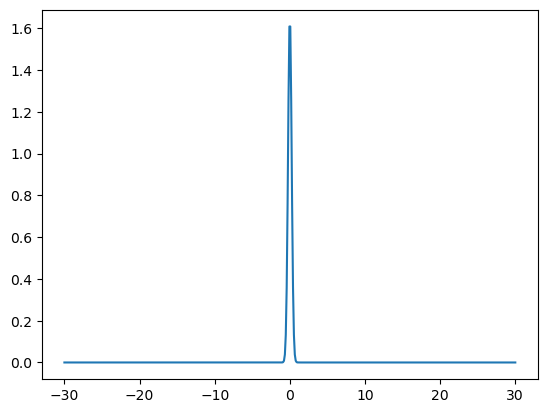

In [16]:
N = 500
L = 30.0
x = np.linspace(-L, L, N)
dx = x[1] - x[0]
V = np.zeros(N)
V = compute_delta_potential(V0,x)
plt.plot(x,V)
print(V[250])
print(x[250])

In [4]:
print(t_num)
print(r_num)

(0.08727119499213078-0.2898262609414366j)
(-0.912615947293425-0.27480285613340627j)


In [5]:
# zoom = x < 20 
# zoom1 = x > -20
# zoom2 = zoom*zoom1
# plt.plot(x, psi)

In [7]:
def compute_delta_potential(V0,x):
    dx = x[1] - x[0]
    sigma = 2*dx
    gaussian = np.exp(-x**2 / (2 * sigma**2))
    # Normalize it so its discrete integral sum(gaussian * dx) = 1
    norm_factor = np.sum(gaussian * dx)
    return V0 * gaussian / norm_factor


In [8]:
import gc
delta_x = 0.01
def analytical_transmission(k_val, V0_val, mass_val, hbar_val):
    
    denominator = k_val + 1j * mass_val * V0_val / hbar_val**2
    t_analytic = k_val / denominator
    
    return np.abs(t_analytic) ** 2

def numerical_transmission(E_val, V0, mass, hbar, L=40.0, N=400):
    k = np.sqrt(2 * mass * E_val) / hbar
    x = np.linspace(-L, L, N)
    dx = x[1] - x[0]
    
    potential = compute_delta_potential(V0,x)
    #           np.array([ (V0 / (dx * np.sqrt(2 * np.pi))) * np.exp(-x_j**2 / (2 * dx**2)) for x_j in x ])
    
    # Full K matrix construction
    K = np.zeros((N, N), dtype=np.complex128)
    gamma = -1j * mass * dx / (hbar**2 * k)
    
    for i in range(N):
        for j in range(N):
            if potential[j] != 0:
                K[i, j] = gamma * potential[j] * np.exp(1j * k * np.abs(x[i] - x[j]))
    
    # Solve linear system
    I = np.eye(N, dtype=np.complex128)
    A = I - K
    phi = np.exp(1j * k * x)
    psi = np.linalg.solve(A, phi)
    
    # plt.plot(x,psi)
    # plt.show()

    # Transmission coefficient extraction
    trans_mask = x > (L/2)
    x_right = x[trans_mask]
    ratios = psi[trans_mask] / np.exp(1j * k * x_right)
    t_num = np.mean(ratios)
    
    refl_mask = x < -(L/2)  # Selected region
    # trans_mask = x > 30   # Selected region

    M_refl = np.vstack([np.exp(1j * k * x[refl_mask]), np.exp(-1j * k * x[refl_mask])]).T
    coeffs = np.linalg.lstsq(M_refl, psi[refl_mask], rcond=None)[0]

    r_num = coeffs[1]
    
    print(f"Numerical |r|^2: {np.abs(r_num)**2:.6f}")

    del A
    del K
    gc.collect()
    
    return np.abs(t_num)**2


In [15]:
# Single-energy comparison (E=2.0)
E = 1.5
V0 = 1.0      # Delta function strength
mass = 1.0    # Particle mass
hbar = (1/5)**0.5  # Reduced Planck's

# Spatial grid parameters
k = np.sqrt(2 * mass * E)/(hbar)
k_current = np.sqrt(2 * mass * E)/(hbar)
t_analytic_current = analytical_transmission(k_current, V0, mass, hbar)
t_numerical_current = numerical_transmission(E, V0, mass, hbar, L = 40.0,N = 5000)  # Replace with actual numerical value

print(f"|t_analytic|²={t_analytic_current:.6f} | |t_numerical|²={t_numerical_current:.6f} | k_current={k_current:.3f}")


Numerical |r|^2: 0.689590
|t_analytic|²=0.375000 | |t_numerical|²=0.310410 | k_current=3.873


In [25]:
del A
gc.collect()

489

Numerical |r|^2: 0.646494
Numerical |r|^2: 0.584398
Numerical |r|^2: 0.533018
Numerical |r|^2: 0.489801
Numerical |r|^2: 0.452945
Numerical |r|^2: 0.421142
Numerical |r|^2: 0.393420
Numerical |r|^2: 0.369041
Numerical |r|^2: 0.347434
Numerical |r|^2: 0.328153
Numerical |r|^2: 0.310842
Numerical |r|^2: 0.295212
Numerical |r|^2: 0.281032
Numerical |r|^2: 0.268108
Numerical |r|^2: 0.256280
Numerical |r|^2: 0.245415
Numerical |r|^2: 0.235399
Numerical |r|^2: 0.226138
Numerical |r|^2: 0.217549
Numerical |r|^2: 0.209561


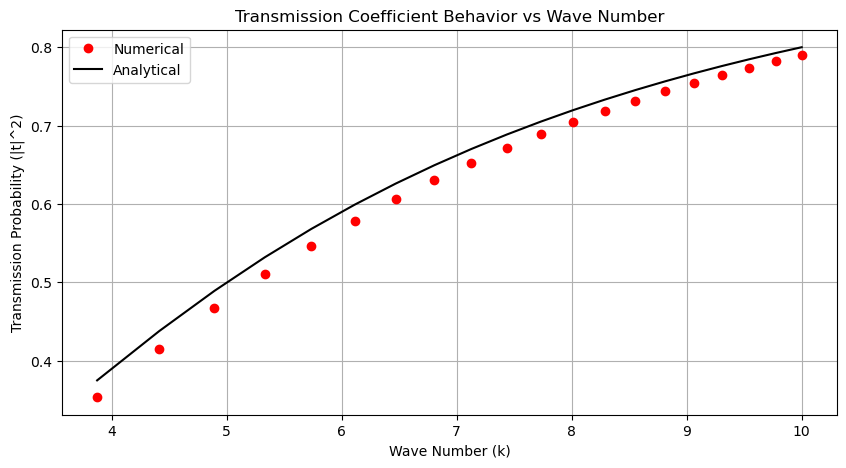

In [6]:
# Transmission coefficient vs wave number analysis
V0 = 1.0
energy_range = np.linspace(1.5, 10, 20)  # Generate E values
k_values = np.sqrt(2 * mass * energy_range) / hbar
analytical_values = [analytical_transmission(k, V0, mass, hbar) for k in k_values]
numerical_values = [numerical_transmission(E, V0, mass, hbar, L = 40.0, N = 5000) for E in energy_range]

plt.figure(figsize=(10, 5))
plt.plot(k_values, numerical_values, 'ro', label='Numerical')
plt.plot(k_values, analytical_values, 'k-', label='Analytical')
plt.xlabel('Wave Number (k)')
plt.ylabel('Transmission Probability (|t|^2)')
plt.title('Transmission Coefficient Behavior vs Wave Number')
plt.legend()
plt.grid(True)
plt.show()



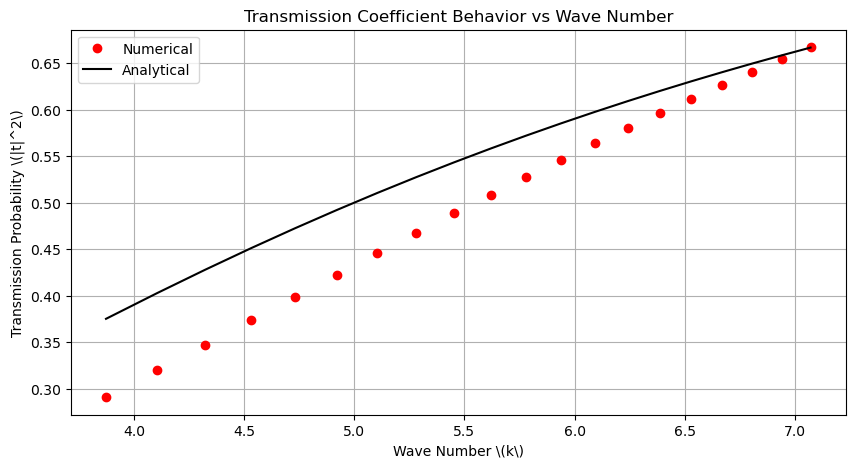

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, numerical_values, 'ro', label='Numerical')
plt.plot(k_values, analytical_values, 'k-', label='Analytical')
plt.xlabel('Wave Number (k)')
plt.ylabel('Transmission Probability (|t|^2)')
plt.title('Transmission Coefficient Behavior vs Wave Number')
plt.legend()
plt.grid(True)
plt.show()